This notebook takes < 3mins to run top-to-bottom.

# This is a notebook for examining adjustments made to raw data after importing and before regridding.

There are 6 RCM outputs used in the paper and 2 reanalysis data products:

| **RCM/Reanalysis Dataset** | **Domain** | **Driving Data** | **H.Resolution [km]** | **Label**   |
|----------------------------|------------|------------------|-----------------------|-------------|
| ERA-Interim                | Global     | -                | 79                    | ERAI        |
| ERA5                       | Global     | -                | 31                    | ERA5        |
| MetUMv11.1                 | Antarctica | ERA-Interim      | 12                    | MetUM(011)  |
| MetUMv11.1                 | Antarctica | ERA-Interim      | 50                    | MetUM(044)  |
| MARv3.10                   | Antarctica | ERA-Interim      | 35                    | MAR(ERAI)   |
| MARv3.10                   | Antarctica | ERA5             | 35                    | MAR(ERA5)   |
| RACMOv2.3p2                | Antarctica | ERA-Interim      | 27                    | RACMO(ERAI) |
| RACMOv2.3p2                | Antarctica | ERA5             | 27                    | RACMO(ERA5) |


## Description of raw data

See '/scripts/Examining Raw Data' to experiment with the raw data.

MetUM(044) & MetUM(011): 
- 2 meter temperature is output at 3 hourly resolution, whereas snowfall and snowmelt are output at 6 hourly resolution.
- The spatial resolutions are 0.44 and 0.11 degrees, which are approximately 49 km and 12.25 km.
- The data comes in year batches and ranges from 1980-to-2018.

MAR(ERAI) & MAR(ERA5): 
- All variables are output at 3 hourly resolution.
- The spatial resolution is approximately 35 km.
- The data comes in 10 year batches and ranges from 1981-to-2018.

RACMO(ERAI) & RACMO(ERA5): 
- All variables are output at 3 hourly resolution.
- The spatial resolution is approximately 27 km.
- The data comes in year batches and ranges from 1979-to-2019.

ERA-Interim & ERA5: 
- All variables are output at 1 hourly resolution for ERA5. Snowfall and snowmelt were downloaded with units of meter water equivalent (mWEq).
- For ERAI, temperature is output as an instantaneous variable at 6 hourly resolution and snowfall/snowmelt are output as 3/6/9/12hour forecasts every 12hours.
- The spatial resolutions are approximately 79 km and 31 km.
- The data comes in year batches and ranges from 1979-to-2019 for ERA-Interim and 1979-approximately present for ERA5.



## Description of process of importing and adjustments made for each raw dataset

See '/scripts/importing_and_adjusting_data.py' for the code used to import the data.

General Process:
- A list of filepaths containing the years requested is made.
- The iris python package is used to load each file as a cube.
- The specific adjustments are made to each cube to unify some aspects such as units and calendars (Note RACMO(ERA5) is output with no leap year coordinates, this means every 4 years it misses a day in February - this is considered insignificant to results)
- Auxilliary coordinates for the day of year, the month and the year are added to the cube.
- Auxilliary 2D latitude and longitude coordinates are added to the cube. This is done by first creating a numpy meshgrid of the 1D 'grid_latitude' and 'grid_longitude' coordinates, which represent an equatorial rotated coordinate system. The 'grid_latitude' and 'grid_longitude' values are those of where the grid is defined over the equator. Then the coordinate values in the meshgrid are rotated using metadata about the rotation used in the simulations. These rotated coordinate values represent the actual latitude and longitude values that each grid-cell represents and are added to the cube.      
- Unnecessary coordinates are removed (e.g. forecast_period)
- The data is aggregated to monthly values. The instantaneous temperature measurements are limited first to [0,6,12,18] before aggregating so the average is consistent across the outputs. 

Specific Adjustments:
- MetUM
    - Values for snowfall and snowmelt in the raw data are in units of kg m-2 s-1 and so represent the average snowfall/snowmelt during the bounds of the time measurement, which for the MetUM if the time coordinate is [2000-01-01 03:00:00], the bounds are [2000-01-01 00:00:00, 2000-01-01 06:00:00]. We want to convert this so the value represents the total snowfall/melt over the 6 hour [2000-01-01 00:00:00, 2000-01-01 06:00:00] period. This involves multiplying the average value by 21600 seconds (6hours).
- MAR
    - Temperature is output in degrees celcius, to convert this to kelvin we add 273.15 to each temperature value.
    - MAR uses a slightly different coordinate system - where instead of having constant grid-latitude and grid-longitude spacing between the cells, constant geodesic distance is used - I've created a function to deal with this but in the end I simply used 2D lat/lon fields available from a MAR mask file and copied this across to the other files.
- RACMO
    - The files come in batches of 10 years. So after loading the data is filtered to the specific years of interest.
    - The RACMO(ERAI) files for snowfall/melt came as accumulative values apart from the 2011 file, which came as an average value per second, to convert this to a 3 hour accumulative value the value is multiplied by 10800.
- ERA-Interim & ERA5
    - Data downloaded for snowfall/melt came in units of mWEq, to convert this to kg m-2 the value is multiplied by the 1000 (note 1 meter square filled with 1 mm of water (mmWEq) is equal to 1kg).
    - For ERAI the values come as 12hour forecasts with timesteps of 3h,6h,9h and 12h where say the 9h timestep is the amount of snowfall accumulated over a 9h timespan since the forecast start. Since I downloaded the data with 00:00 and 12:00 forecasts and 3/6/9/12h steps, I filter to 3::4, which means start at the 4th element (index 3) and then take steps of 4. This gives me 12h estimates of snowfall/melt accumulation, so instead of [2000-01-01 03:00:00, 2000-01-01 06:00:00, 2000-01-01 09:00:00, ...] time measurements we have [2000-01-01 12:00:00, 2000-01-02 00:00:00, 2000-01-02 12:00:00,...].
    


## Examining Imported and Processed Data

In [1]:
from src.helper_functions import examine_postprocessed_data

In [2]:
year = 2000
folder_path = '/home/users/carter10/Shared_Storage/Antarctica_Climate_Variability/Postprocessed_Data/'

### Near-Surface Air Temperature

In [6]:
examine_postprocessed_data(f'MetUM_044_ERA_INT_tas_{year}.nc',folder_path)
examine_postprocessed_data(f'MetUM_011_ERA_INT_tas_{year}.nc',folder_path)
examine_postprocessed_data(f'MAR_35_ERA_INT_TT_{year}.nc',folder_path)
examine_postprocessed_data(f'MAR_35_ERA5_TT_{year}.nc',folder_path)
examine_postprocessed_data(f'RACMO_27_ERA_INT_t2m_{year}.nc',folder_path)
examine_postprocessed_data(f'RACMO_27_ERA5_t2m_{year}.nc',folder_path)
examine_postprocessed_data(f'ERA-Interim_79_NA_2mtemp_{year}.nc',folder_path)
examine_postprocessed_data(f'ERA5_31_NA_2mtemp_{year}.nc',folder_path)

MetUM_044_ERA_INT_tas_1981.nc
air_temperature / (K)               (time: 12; grid_latitude: 98; grid_longitude: 126)
     Dimension coordinates:
          time                           x                  -                   -
          grid_latitude                  -                  x                   -
          grid_longitude                 -                  -                   x
     Auxiliary coordinates:
          day_of_year                    x                  -                   -
          month                          x                  -                   -
          year                           x                  -                   -
          latitude                       -                  x                   x
          longitude                      -                  x                   x
     Attributes:
          Conventions: CF-1.7
     Cell methods:
          mean: month, year
Data:
Units = K
0:1000 Temporal Mean = 253.66994
Time:
Start Date = [cftime.D

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 't2m' contains unknown cell method 'instantaneous'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


0:1000 Temporal Mean = 261.6916
Time:
Start Date = [cftime.DatetimeGregorian(1981, 1, 16, 9, 0, 0, 0)]
End Date = [cftime.DatetimeGregorian(1981, 12, 16, 9, 0, 0, 0)]
Units = days since 1979-01-01 00:00:00
Frequency = 29.5
RACMO_27_ERA5_t2m_1981.nc
air_temperature / (K)               (time: 12; grid_latitude: 240; grid_longitude: 262)
     Dimension coordinates:
          time                           x                  -                    -
          grid_latitude                  -                  x                    -
          grid_longitude                 -                  -                    x
     Auxiliary coordinates:
          day_of_year                    x                  -                    -
          month                          x                  -                    -
          year                           x                  -                    -
          latitude                       -                  x                    x
          longitude       

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 't2m' contains unknown cell method 'instantaneous'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


0:1000 Temporal Mean = 261.9661
Time:
Start Date = [cftime.DatetimeGregorian(1981, 1, 16, 9, 0, 0, 0)]
End Date = [cftime.DatetimeGregorian(1981, 12, 16, 9, 0, 0, 0)]
Units = days since 1979-01-01 00:00:00
Frequency = 29.5
ERA-Interim_79_NA_2mtemp_1981.nc
air_temperature / (K)               (time: 12; grid_latitude: 81; grid_longitude: 81)
     Dimension coordinates:
          time                           x                  -                   -
          grid_latitude                  -                  x                   -
          grid_longitude                 -                  -                   x
     Auxiliary coordinates:
          day_of_year                    x                  -                   -
          month                          x                  -                   -
          year                           x                  -                   -
          latitude                       -                  x                   x
          longitude         

### Snowfall

In [7]:
examine_postprocessed_data(f'MetUM_044_ERA_INT_mean_prsn_{year}.nc',folder_path)
examine_postprocessed_data(f'MetUM_011_ERA_INT_mean_prsn_{year}.nc',folder_path)
examine_postprocessed_data(f'MAR_35_ERA_INT_SNF_{year}.nc',folder_path)
examine_postprocessed_data(f'MAR_35_ERA5_SNF_{year}.nc',folder_path)
examine_postprocessed_data(f'RACMO_27_ERA_INT_snowfall_{year}.nc',folder_path)
examine_postprocessed_data(f'RACMO_27_ERA5_snowfall_{year}.nc',folder_path)
examine_postprocessed_data(f'ERA-Interim_79_NA_snowfall_{year}.nc',folder_path)
examine_postprocessed_data(f'ERA5_31_NA_snowfall_{year}.nc',folder_path)

MetUM_044_ERA_INT_mean_prsn_1981.nc
snowfall_flux / (kg m-2 s-1)        (time: 12; grid_latitude: 98; grid_longitude: 126)
     Dimension coordinates:
          time                           x                  -                   -
          grid_latitude                  -                  x                   -
          grid_longitude                 -                  -                   x
     Auxiliary coordinates:
          day_of_year                    x                  -                   -
          month                          x                  -                   -
          year                           x                  -                   -
          latitude                       -                  x                   x
          longitude                      -                  x                   x
     Attributes:
          Conventions: CF-1.7
     Cell methods:
          mean: time (1 hour)
          sum: month, year
Data:
Units = kg m-2 s-1
0:1000 Temporal M

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 'snowfall' contains unknown cell method '3'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


RACMO_27_ERA_INT_snowfall_1981.nc
snowfall_flux / (kg m-2 s-1)        (time: 12; grid_latitude: 240; grid_longitude: 262)
     Dimension coordinates:
          time                           x                  -                    -
          grid_latitude                  -                  x                    -
          grid_longitude                 -                  -                    x
     Auxiliary coordinates:
          day_of_year                    x                  -                    -
          month                          x                  -                    -
          year                           x                  -                    -
          latitude                       -                  x                    x
          longitude                      -                  x                    x
     Attributes:
          Conventions: CF-1.7
     Cell methods:
          3: time
          sum: month, year
Data:
Units = kg m-2 s-1
0:1000 Temporal Mean =

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 'snowfall' contains unknown cell method '3'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


0:1000 Temporal Mean = 35.335945
Time:
Start Date = [cftime.DatetimeGregorian(1981, 1, 16, 10, 30, 0, 0)]
End Date = [cftime.DatetimeGregorian(1981, 12, 16, 10, 30, 0, 0)]
Units = days since 1979-01-01 00:00:00
Frequency = 29.5
ERA-Interim_79_NA_snowfall_1981.nc
UNKNOWN LOCAL PARAM 144.128 / (1)   (time: 12; grid_latitude: 81; grid_longitude: 81)
     Dimension coordinates:
          time                           x                  -                   -
          grid_latitude                  -                  x                   -
          grid_longitude                 -                  -                   x
     Auxiliary coordinates:
          day_of_year                    x                  -                   -
          month                          x                  -                   -
          year                           x                  -                   -
          latitude                       -                  x                   x
          longitude  

In [18]:
folder_path = '/home/users/carter10/Shared_Storage/Antarctica_Climate_Variability/Regridded_Data/'

In [19]:
import iris
import os
import iris.quickplot as qplt 
import matplotlib.pyplot as plt
from src.ploter_functions import pcolormesh_basemapplot
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap

In [20]:
cube = iris.load(f'{folder_path}MAR_35_ERA5_SNF_{2000}.nc')[0]

In [21]:
cube = cube.collapsed(['time'],iris.analysis.SUM)

In [22]:
cube

<iris 'Cube' of cube_regridded / (1) (-- : 392; -- : 504)>

In [23]:
antarctica_map = Basemap(width=6600000,height=6600000,projection='laea',lat_ts=-55,lat_0=-90,lon_0=0,resolution='f')

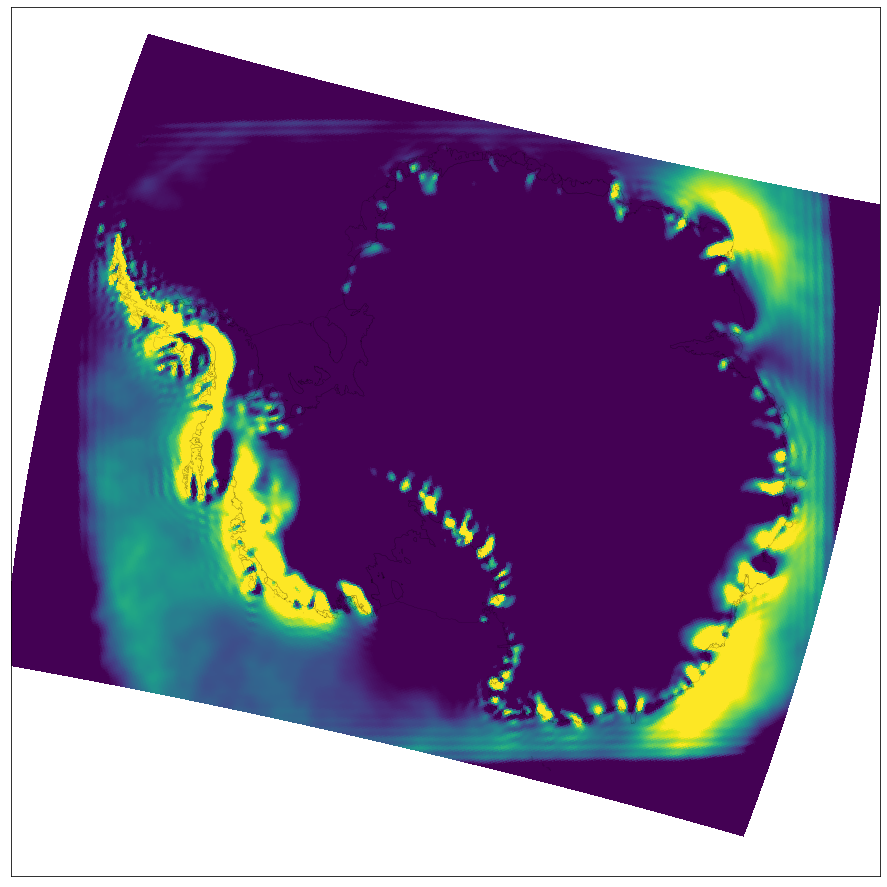

In [24]:
plt.figure(figsize=(16,16))
pcolormesh_basemapplot(cube,antarctica_map,300,700,cmap='viridis')

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'x' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'y' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


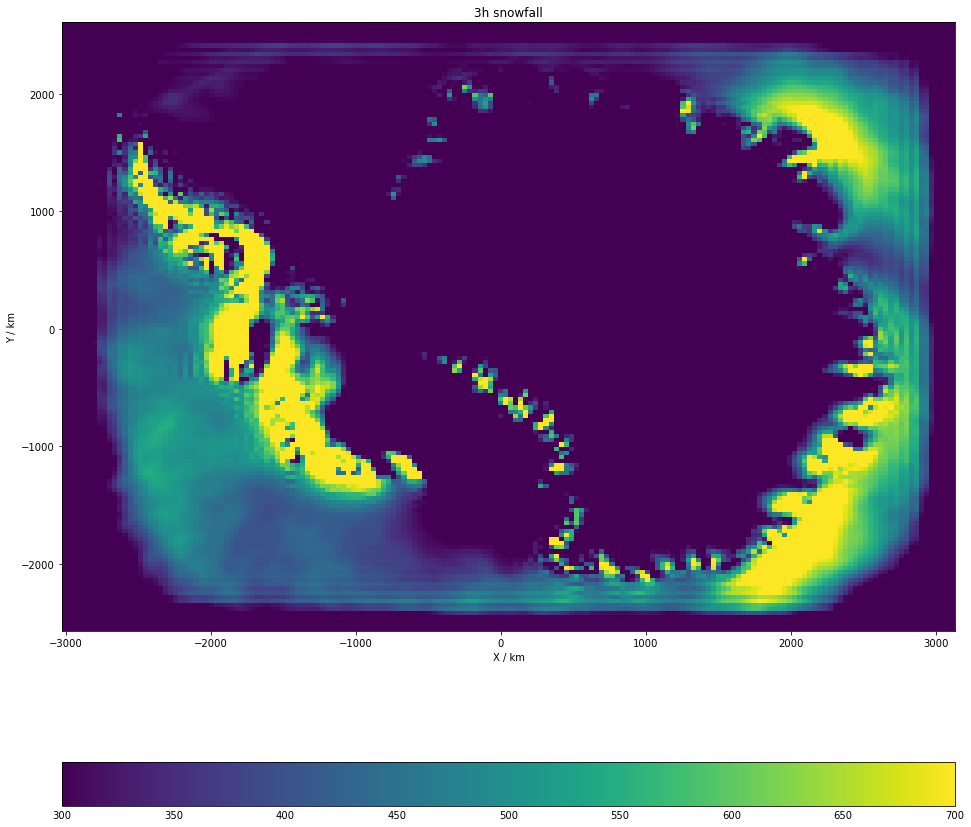

In [8]:
plt.figure(figsize=(16,16))
qplt.pcolormesh(cube,vmin=300,vmax=700)

In [ ]:
f'MAR_35_ERA5_SNF_{year}.nc'

### Melt

In [28]:
import iris
import numpy as np

In [43]:
cube = iris.load(folder_path+f'ERA-Interim_79_NA_snowmelt_{year}.nc')

In [42]:
#folder_path2 = '/home/users/carter10/Shared_Storage/Antarctica_Climate_Variability/Regridded_Data/'
cube2 = iris.load(folder_path+f'ERA5_31_NA_snowmelt_{year}.nc')

In [48]:
cube[0].data

masked_array(
  data=[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.,

In [47]:
cube2[0].data

masked_array(
  data=[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.,

In [39]:
np.nanmean(cube[0].data)

0.69943744

In [40]:
np.nanmean(cube2[0].data)

0.33330623529872

In [33]:
cube[0][:,235,55].data.mean()

22.855850219726562

In [41]:
cube2[0][:,0,0].data

masked_array(data=[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             mask=False,
       fill_value=1e+20)

In [25]:
cube2[0].data.data.mean()

0.33330623529872

In [3]:
examine_postprocessed_data(f'MetUM_044_ERA_INT_mean_snm_{year}.nc',folder_path)
examine_postprocessed_data(f'MetUM_011_ERA_INT_mean_snm_{year}.nc',folder_path)
examine_postprocessed_data(f'MAR_35_ERA_INT_ME_{year}.nc',folder_path)
examine_postprocessed_data(f'MAR_35_ERA5_ME_{year}.nc',folder_path)
examine_postprocessed_data(f'RACMO_27_ERA_INT_snowmelt_{year}.nc',folder_path)
examine_postprocessed_data(f'RACMO_27_ERA5_snowmelt_{year}.nc',folder_path)
examine_postprocessed_data(f'ERA-Interim_79_NA_snowmelt_{year}.nc',folder_path)
examine_postprocessed_data(f'ERA5_31_NA_snowmelt_{year}.nc',folder_path)

MetUM_044_ERA_INT_mean_snm_2000.nc
surface_snow_melt_flux_where_land / (kg m-2 s-1) (time: 12; grid_latitude: 98; grid_longitude: 126)
     Dimension coordinates:
          time                                        x                  -                   -
          grid_latitude                               -                  x                   -
          grid_longitude                              -                  -                   x
     Auxiliary coordinates:
          day_of_year                                 x                  -                   -
          month                                       x                  -                   -
          year                                        x                  -                   -
          latitude                                    -                  x                   x
          longitude                                   -                  x                   x
     Attributes:
          Conventions: CF-1.7
  

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 'snowmelt' contains unknown cell method '3'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


RACMO_27_ERA_INT_snowmelt_2000.nc
Snow Melt Flux / (kg m-2)           (time: 12; grid_latitude: 240; grid_longitude: 262)
     Dimension coordinates:
          time                           x                  -                    -
          grid_latitude                  -                  x                    -
          grid_longitude                 -                  -                    x
     Auxiliary coordinates:
          day_of_year                    x                  -                    -
          month                          x                  -                    -
          year                           x                  -                    -
          latitude                       -                  x                    x
          longitude                      -                  x                    x
     Attributes:
          Conventions: CF-1.7
     Cell methods:
          3: time
          sum: month, year
Data:
Units = kg m-2
Mean = 0.10305455
Sum = 77

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 'snowmelt' contains unknown cell method '3'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


RACMO_27_ERA5_snowmelt_2000.nc
Snow Melt Flux / (kg m-2 s-1)       (time: 12; grid_latitude: 240; grid_longitude: 262)
     Dimension coordinates:
          time                           x                  -                    -
          grid_latitude                  -                  x                    -
          grid_longitude                 -                  -                    x
     Auxiliary coordinates:
          day_of_year                    x                  -                    -
          month                          x                  -                    -
          year                           x                  -                    -
          latitude                       -                  x                    x
          longitude                      -                  x                    x
     Attributes:
          Conventions: CF-1.7
     Cell methods:
          3: time
          sum: month, year
Data:
Units = kg m-2 s-1
Mean = 0.103496484
Sum = 

In [3]:
print(46538*49000**2/10**12,
      87406*35000**2/10**12,
      77760*27000**2/10**12,
      28775*83500**2/10**12,
      30309*27800**2/10**12)

111.737738 107.07235 56.68704 200.62649375 23.42400756


In [1]:
30309*31000**2/10**12

29.126949

In [10]:
import os
import iris
import iris.quickplot as qplt 
import numpy as np
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap
from src.helper_functions import examine_postprocessed_data
from src.helper_functions import examine_regridded_data
from src.ploter_functions import pcolormesh_basemapplot

In [13]:
cube = iris.load(f'{folder_path}ERA-Interim_79_NA_snowmelt_{year}.nc')[0]

/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_year'.
  warnings.warn(msg.format(self.name()))
/home/users/carter10/.conda/envs/cordex-analysis-env/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
/home/users/carter10/Antarctica_Climate_Variability/src/ploter_functions.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  return(basemap.pcolormesh(longitudes,latitudes,cube.data,vmin=vmin,vmax=vmax, latlon=True, cmap=cmap, shading = 'nearest',alpha=alpha))


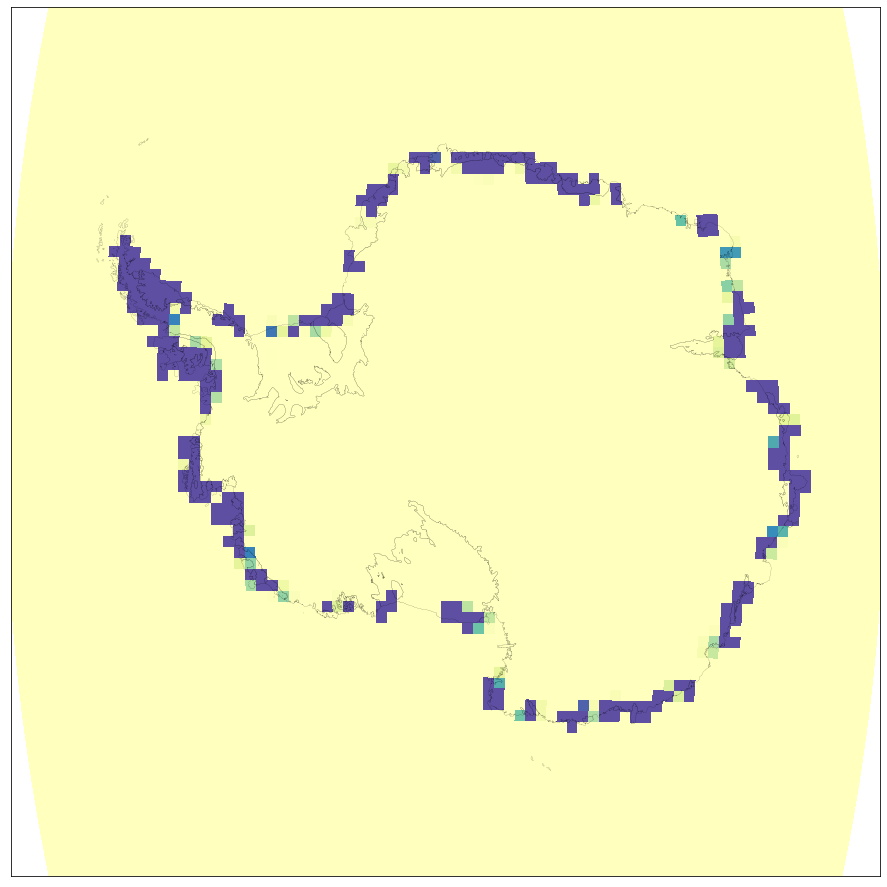

In [14]:
plt.figure(figsize=(16,16))
antarctica_map = Basemap(width=6600000,height=6600000,projection='laea',lat_ts=-55,lat_0=-90,lon_0=0,resolution='f')
pcolormesh_basemapplot(cube.collapsed('time',iris.analysis.SUM),antarctica_map,-5,5,cmap='Spectral')
